# Collect and Analyze a Twitter Network
[Effrosyni Simou](http://lts4.epfl.ch/simou), *PhD Student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
In this way you will have this information readily available to you. 

In [1]:
%matplotlib inline
import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tweepy  # you will need to install tweepy first

In [2]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')
# authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))
# construct API instance, deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [3]:
username = 'appliedmldays'
user = api.get_user(username)
user_id = user.id

In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user.

In [4]:
def find_connections(userid):
    """
    Find connection for a given userid. (Both ID have to follow each other to be defined as connection,
    bi-directional edge)
    :param userid:  User to find connection with
    :return:        Set of IDs connected to this user
    """
    # Query follower and following IDs
    connections = set()
    try:
        followers = [x for x in tweepy.Cursor(api.followers_ids,
                                              user_id=userid).items()]
        #set(api.followers_ids(user_id=userid))
        followings = [x for x in tweepy.Cursor(api.friends_ids,
                                              user_id=userid).items()]
        #set(api.friends_ids(user_id=userid))
        connections = set(followers).intersection(set(followings))
    except tweepy.TweepError:
        print('Can not access user properties')
    return connections

In [6]:
first_connections = find_connections(user_id)
print('{} has {} connections'.format(username, len(first_connections)))

appliedmldays has 139 connections


Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [7]:
def check_user_access_and_sample(userids, n=None):
    """
    Check if users given in the set have protected profile. If it is the case
    they get discarded. While checking for valid user, it is possible to
    sample n users randomly.
    :param userids: List of user to check their profile validity
    :param n:       Number of user to sample
    :return:        Selected user with non protected account
    """
    # Shuffle first if needed
    selection = set()
    if n is not None:
        users = np.random.permutation(list(userids))
        N = n
    else:
        users = list(userids)
        N = len(userids)
    # start sampling
    cnt = 0
    for ids in users:
        user = api.get_user(ids)
        if not user.protected:
            # Can access user info
            selection.add(ids)
            cnt += 1
            if cnt >= N:
                break
        else:
            print('User is protected, skip it')
    return selection

def second_connections(userids, n=None):
    """
    Given a list IDs find connection for each of them
    :param userids: List of IDs to find connection for
    :param n: Number of ID to ramdonly pick from connections. If None,
    take all of them
    :return:    List of connections (2nd level)
    """
    connections = set()
    # Look for connections
    for ids in userids:
        # Query user information
        conn = find_connections(ids)
        conn = check_user_access_and_sample(conn, n)
        # Add sampled connections to the already existing collection
        connections = connections.union(conn)
    return connections

In [27]:
network={}
#This is the number of connections you are sampling.Keep small (e.g.3) for development, larger later (e.g. 10)
how_many = 15
# Collect first nodes (store in set for convenience)
first_connections = find_connections(user_id)
first_nodes = check_user_access_and_sample(first_connections, how_many)
second_nodes = second_connections(first_nodes, how_many)

User is protected, skip it
Rate limit reached. Sleeping for: 537
User is protected, skip it
User is protected, skip it
User is protected, skip it


**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [28]:
network[user_id] = first_nodes

In [29]:
pprint(network)

{763052115392593920: {25260440,
                      32172572,
                      34566614,
                      123969580,
                      201991896,
                      392695595,
                      841497890,
                      862060568,
                      1398176894,
                      2564347228,
                      2827458676,
                      4142688494,
                      4887296745,
                      702870499639095296,
                      846330801138651136}}


In [30]:
all_nodes = first_nodes.union(second_nodes)
all_nodes.add(user_id)

In [31]:
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 15 first hop nodes
There are 153 second hop nodes
There are overall 168 nodes in the collected network


In [32]:
for i in all_nodes:
     network[i]= set()

Find the inner connections between your collected nodes that you might have missed because you sampled the connections.

In [33]:
for ids in all_nodes:
    print('Search connections for {}'.format(ids))
    conn = find_connections(ids)
    conn = conn.intersection(all_nodes)
    network[ids] = network[ids].union(conn)
    for c in conn:
        network[c].add(ids)

Search connections for 702870499639095296
Search connections for 846330801138651136
Rate limit reached. Sleeping for: 783
Search connections for 763052115392593920
Search connections for 740179601503223809
Search connections for 798092147425681409
Search connections for 725639768663576576
Search connections for 724532781720702976
Search connections for 771678618711883776
Search connections for 887968270724235265
Search connections for 778963414756433920
Search connections for 846431217088184321
Search connections for 905116529141927940
Search connections for 197593109
Search connections for 862060568
Search connections for 4794632221
Search connections for 2324111390
Rate limit reached. Sleeping for: 824
Search connections for 2267495456
Search connections for 2171884577
Search connections for 51570722
Search connections for 893928482
Search connections for 3345454120
Search connections for 123969580
Search connections for 1632704557
Search connections for 276184113
Search connections 

Search connections for 840230322897739776
Search connections for 307463963
Search connections for 335246117
Search connections for 392695595
Search connections for 105305900
Search connections for 2280451885
Search connections for 123189036
Search connections for 289582896
Search connections for 1112553272
Search connections for 29921080
Search connections for 489634618
Search connections for 50812731
Search connections for 73681726
Search connections for 477855555
Rate limit reached. Sleeping for: 821
Search connections for 4153160533
Search connections for 15221598
Search connections for 2324100967
Search connections for 1172413292
Search connections for 1349024622
Search connections for 2192241
Search connections for 1192562556
Search connections for 33315710
Search connections for 763368160527544320
Search connections for 721298749448974336
Rate limit reached. Sleeping for: 820
Search connections for 773244981645602816
Search connections for 849184601415315456
Search connections fo

In [112]:
# Just in case, save data
np.save('network.npy', network) 

# 2. Discover some of the properties of the collected network

## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [34]:
# pprint(network)
W=np.zeros([len(all_nodes),len(all_nodes)], dtype=np.int32)

In [46]:
# your code here
nodes = list(all_nodes)
for i, ids in enumerate(nodes):
    conn = list(network[ids])
    for k in conn:
        j = nodes.index(k)
        W[i, j] = 1

Remember that a weight matrix should be symmetric. Check if it is:

In [47]:
np.nonzero(W-W.transpose())

(array([], dtype=int64), array([], dtype=int64))

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

**Your answer here:**
At the moment we are considering undriected edges since both people $i$ and $j$ have to follow each other, therefore the matrix will be symmetric. However if we consider undirected edges (i.e. Person $i$ is following $j$ but $j$ is not necessarly following $i$) we'll end up with a non-symmetric matrix.

Impose your weight matrix to be symmetric.

In [48]:
# Make W is symmetric
bigger = W.transpose() > W

In [49]:
W = W - W*bigger + W.transpose()*bigger

Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

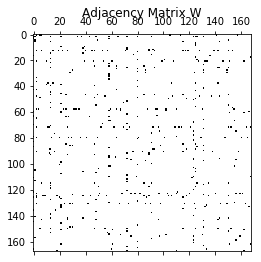

In [50]:
# your code here
plt.title('Adjacency Matrix W')
plt.spy(W)

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

**Your answer here:**
From the definition $L_{max} = \frac{N\left(N - 1\right)}{2}$ = 14028 for the collected network. There is a total of $L = \frac{1}{2}\sum W_{ij} = 257$ links. It shows that the sampled  tweeter network is very sparse.

In [52]:
Lmax = len(all_nodes) * (len(all_nodes) - 1) / 2
L = np.count_nonzero(W) / 2
print("Lmax is {}".format(Lmax))
print("L is {}".format(L))

Lmax is 14028.0
L is 257.0


## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

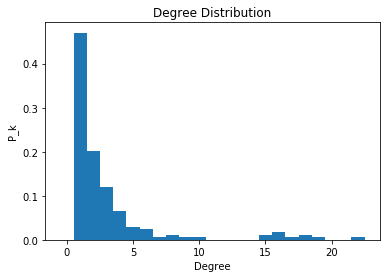

In [109]:
degree = []
for ids, nodes in network.items():
    e = len(nodes)
    degree.append(e)
degree.sort()
max_degree = degree[-1]
p = [0] * (max_degree + 1)
for d in degree:
    p[d] += 1
# Normalize
sum_p = sum(p)
p = list(map(lambda x: float(x) / sum_p, p))
xbin = np.arange(len(p))
plt.bar(xbin, p, align='center', width=1.0)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('P_k')
plt.show()

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

**Your answer here:**
Most of the nodes in the sampled network have a small degree $k \in \left[1, 4\right]$ and only a few nodes have a degree $k \geq 15$. In general this is what is expected since most of the people have some connections and few people have much more than that. Regarding the complete network I would expect to have similar distribution but shifted toward higher degrees.  

## 2.3 Average degree

Calculate the average degree of your collected network.

In [54]:
d_avg = 2 * L / len(all_nodes)
print('Average degree: {0:.3f}'.format(d_avg))

Average degree: 3.060


## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

$$\begin{align}d_{max} &= \max N_{i,j} \quad \forall i,j \\ &= 16\end{align}$$

In [55]:
def longer_path(net):
    """
    Compute the longest shortest path for a given network using BFS approach
    :param net: Network to find the diameter
    :return:    Diameter of the given network
    """
    nodes = list(net.keys())
    N = len(nodes)
    max_d = 0
    for i, node in enumerate(nodes):
        visited = [False] * N
        dist = [-1] * N
        stack = []
        stack.append(node)
        dist[i] = 0
        while len(stack) != 0:
            curr_n = stack.pop()
            curr_idx = nodes.index(curr_n)
            # Check if already visited
            if not visited[curr_idx]:
                visited[curr_idx] = True
                d = dist[curr_idx]
                # Label other
                childs = list(net[curr_n])
                for c in childs:
                    if dist[nodes.index(c)] == -1:
                        dist[nodes.index(c)] = d + 1
                    stack.append(c)
        max_d = max([max_d, max(dist)])
    return max_d

dmax = longer_path(network)
print('Network diameter: {}'.format(dmax))

Network diameter: 16


## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [110]:
# Find how many nodes have a degree higher than <k>
pruned_nodes = []
for ids, childs in network.items():
    k = float(len(childs))
    if k > d_avg:
        # print('{}, {} as a degree of {}'.format(cnt, ids, k))
        pruned_nodes.append(ids)
print('There are {} nodes left, initially {}, iter {}'.format(len(pruned_nodes), len(all_nodes), cnt))
# Prune the collected network
pruned_network = {}
for ids, conn in network.items():
    # ids survived ?
    if ids in pruned_nodes:
        links = set()
        for c in conn:
            if c in pruned_nodes:
                links.add(c)
        pruned_network[ids] = links
# Init adjacency matrix with proper dimension + fill it
Wpruned = np.zeros([len(pruned_nodes),len(pruned_nodes)], dtype=np.int32)
for i, ids in enumerate(pruned_nodes):
    conn = list(pruned_network[ids])
    for k in conn:
        j = pruned_nodes.index(k)
        Wpruned[i, j] = 1
# Sanity check
np.nonzero(Wpruned - Wpruned.transpose())

There are 35 nodes left, initially 168, iter 168


(array([], dtype=int64), array([], dtype=int64))

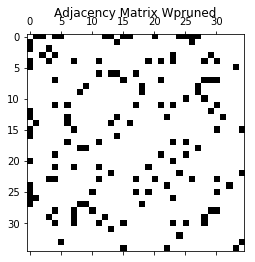

In [111]:
plt.title('Adjacency Matrix Wpruned')
plt.spy(Wpruned)